In [16]:
library(tidyverse)

sessions<-read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

sessions_tidy<-sessions|>
     mutate(start_time=paste(start_time,":00"),
     end_time=paste(end_time,":00"),
     start_time=dmy_hms(start_time),
     end_time=dmy_hms(end_time))|>
     select(start_time,end_time)|>
     mutate(year_start=year(start_time),month_start=month(start_time),day_start=day(start_time),
     hour_start=hour(start_time),minute_start=minute(start_time),startwday=wday(start_time,label=TRUE,abbr=TRUE))|>
     mutate(year_end=year(end_time),month_end=month(end_time),day_end=day(end_time),
     hour_end=hour(end_time),minute_end=minute(end_time),endwday=wday(end_time,label=TRUE,abbr=TRUE))
head(sessions_tidy)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `end_time = dmy_hms(end_time)`.
Caused by warning:
!  2 failed to parse.”


start_time,end_time,year_start,month_start,day_start,hour_start,minute_start,startwday,year_end,month_end,day_end,hour_end,minute_end,endwday
<dttm>,<dttm>,<dbl>,<dbl>,<int>,<int>,<int>,<ord>,<dbl>,<dbl>,<int>,<int>,<int>,<ord>
2024-06-30 18:12:00,2024-06-30 18:24:00,2024,6,30,18,12,Sun,2024,6,30,18,24,Sun
2024-06-17 23:33:00,2024-06-17 23:46:00,2024,6,17,23,33,Mon,2024,6,17,23,46,Mon
2024-07-25 17:34:00,2024-07-25 17:57:00,2024,7,25,17,34,Thu,2024,7,25,17,57,Thu
2024-07-25 03:22:00,2024-07-25 03:58:00,2024,7,25,3,22,Thu,2024,7,25,3,58,Thu
2024-05-25 16:01:00,2024-05-25 16:12:00,2024,5,25,16,1,Sat,2024,5,25,16,12,Sat
2024-06-23 15:08:00,2024-06-23 17:10:00,2024,6,23,15,8,Sun,2024,6,23,17,10,Sun


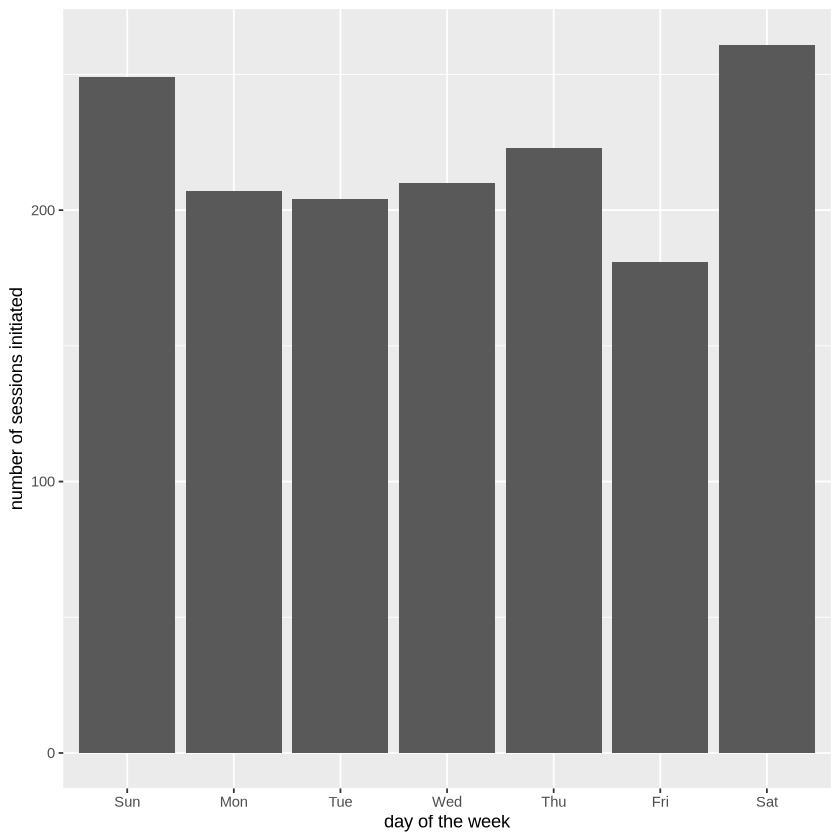

In [18]:
bydayofweek<-ggplot(sessions_tidy,aes(x=startwday))+
geom_bar()+
labs(x="day of the week",y="number of sessions initiated")
bydayofweek

Here, this graph shows that there were some trends in which day of the week had the highest plays. Interestingly, there were less sessions started on Friday compared to any other day. This graph shows that the weekends had higher playership, which is expected since eople usually have more free time on the weekends.

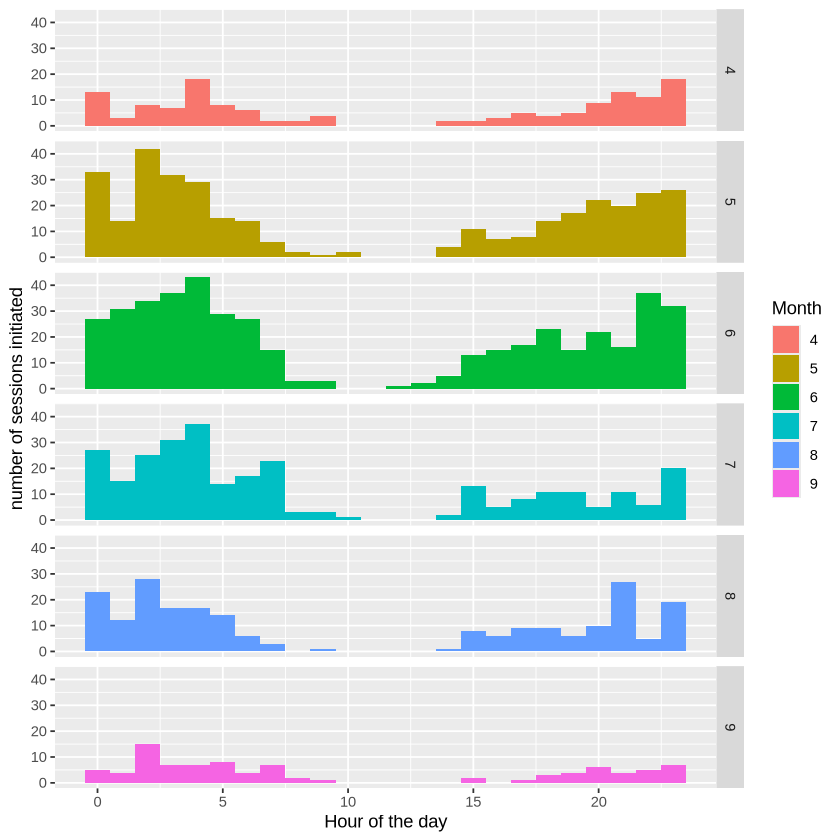

In [19]:
#this one needs to be redone to compensate for the potential lack of data in september
byhour<-ggplot(sessions_tidy,aes(x=hour_start,fill=as_factor(month_start)))+
geom_histogram(bins=24)+
facet_grid(rows = vars(month_start))+
labs(x="Hour of the day",y="number of sessions initiated",fill="Month")
byhour

Here we can see that most sessions are initated around 10pm to 5am.

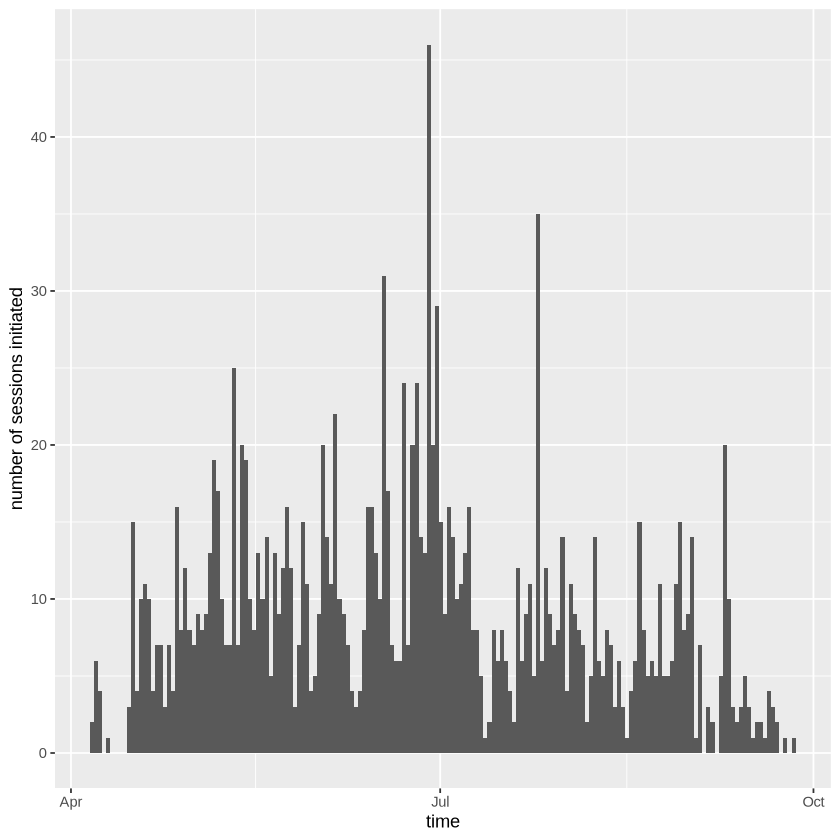

In [47]:
#Someone please find out how over how many days the data was collected and set that as the number of bins.
#first recorded day is April 6th, 2024, and the last is September 26th, 2024
over_time<-ggplot(sessions_tidy,aes(x=start_time))+
geom_histogram(bins=174)+
labs(x="time",y="number of sessions initiated")
over_time